# FlowUtils Transform Comparison: FL1-FL2 Analysis

This notebook demonstrates and compares different transform approaches for flow cytometry data:
- Linear (no transform)
- Log-log transformation
- Hyperlog transformation
- Logicle transformation

We'll use simulated FL1-FL2 fluorescence data that mimics real flow cytometry measurements.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from flowutils import transforms
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 10

## 1. Generate Simulated FL1-FL2 Flow Cytometry Data

We'll create realistic flow cytometry data with:
- Multiple populations with different fluorescence intensities
- Background/autofluorescence (low/negative values)
- Positive populations with varying intensities
- Some measurement noise

In [2]:
# Set random seed for reproducible results
np.random.seed(42)

# Create realistic flow cytometry data with multiple populations
n_events = 10000

# Population 1: Negative/autofluorescence (FL1-, FL2-)
n1 = 3000
fl1_neg = np.random.normal(-50, 30, n1)
fl2_neg = np.random.normal(-20, 25, n1)

# Population 2: FL1+ FL2- (single positive)
n2 = 2000  
fl1_pos_single = np.random.lognormal(np.log(500), 0.6, n2)
fl2_pos_single = np.random.normal(10, 40, n2)

# Population 3: FL1- FL2+ (single positive)
n3 = 2000
fl1_neg_single = np.random.normal(20, 50, n3)
fl2_pos_single = np.random.lognormal(np.log(800), 0.5, n3)

# Population 4: FL1+ FL2+ (double positive)
n4 = 2000
fl1_double_pos = np.random.lognormal(np.log(1200), 0.4, n4)
fl2_double_pos = np.random.lognormal(np.log(1500), 0.4, n4)

# Population 5: Bright population (high intensity)
n5 = 1000
fl1_bright = np.random.lognormal(np.log(5000), 0.3, n5)
fl2_bright = np.random.lognormal(np.log(8000), 0.3, n5)

# Combine all populations
fl1_data = np.concatenate([fl1_neg, fl1_pos_single, fl1_neg_single, fl1_double_pos, fl1_bright])
fl2_data = np.concatenate([fl2_neg, fl2_pos_single, fl2_pos_single, fl2_double_pos, fl2_bright])

# Create combined data matrix (FL1, FL2)
fcs_data = np.column_stack([fl1_data, fl2_data])

print(f"Generated {len(fcs_data)} events with 2 channels (FL1, FL2)")
print(f"FL1 range: {fl1_data.min():.1f} to {fl1_data.max():.1f}")
print(f"FL2 range: {fl2_data.min():.1f} to {fl2_data.max():.1f}")
print(f"FL1 negative values: {np.sum(fl1_data < 0)} events")
print(f"FL2 negative values: {np.sum(fl2_data < 0)} events")

Generated 10000 events with 2 channels (FL1, FL2)
FL1 range: -148.8 to 16315.9
FL2 range: -99.4 to 19269.8
FL1 negative values: 3551 events
FL2 negative values: 2402 events


## 2. Apply Different Transformations

Now we'll apply the different transformation methods to our FL1-FL2 data.

In [3]:
# Transform parameters (typical for flow cytometry)
T = 262144  # Top of scale  
M = 4.5     # Number of decades
W = 0.5     # Width of linear region
A = 0       # Additional negative decades

print(f"Transform parameters: T={T}, M={M}, W={W}, A={A}")

# 1. Linear (no transform) - just copy the data
linear_data = fcs_data.copy()

# 2. Log transform (with offset to handle negative values)
# Add offset to make all values positive, then log transform
offset = abs(fcs_data.min()) + 1
log_data = np.log10(fcs_data + offset)

# 3. Hyperlog transform
hyperlog_data = transforms.hyperlog(fcs_data, channel_indices=[0, 1], t=T, m=M, w=W, a=A)

# 4. Logicle transform  
logicle_data = transforms.logicle(fcs_data, channel_indices=[0, 1], t=T, m=M, w=W, a=A)

print("\nTransform ranges:")
print(f"Linear    FL1: {linear_data[:, 0].min():.1f} to {linear_data[:, 0].max():.1f}")
print(f"Linear    FL2: {linear_data[:, 1].min():.1f} to {linear_data[:, 1].max():.1f}")
print(f"Log       FL1: {log_data[:, 0].min():.3f} to {log_data[:, 0].max():.3f}")
print(f"Log       FL2: {log_data[:, 1].min():.3f} to {log_data[:, 1].max():.3f}")
print(f"Hyperlog  FL1: {hyperlog_data[:, 0].min():.3f} to {hyperlog_data[:, 0].max():.3f}")
print(f"Hyperlog  FL2: {hyperlog_data[:, 1].min():.3f} to {hyperlog_data[:, 1].max():.3f}")
print(f"Logicle   FL1: {logicle_data[:, 0].min():.3f} to {logicle_data[:, 0].max():.3f}")
print(f"Logicle   FL2: {logicle_data[:, 1].min():.3f} to {logicle_data[:, 1].max():.3f}")

Transform parameters: T=262144, M=4.5, W=0.5, A=0

Transform ranges:
Linear    FL1: -148.8 to 16315.9
Linear    FL2: -99.4 to 19269.8
Log       FL1: 0.000 to 4.217
Log       FL2: 1.702 to 4.288
Hyperlog  FL1: -0.006 to 0.730
Hyperlog  FL2: 0.027 to 0.746
Logicle   FL1: -0.028 to 0.731
Logicle   FL2: 0.010 to 0.748


## 3. Create FL1-FL2 Scatter Plots Comparison

Now let's visualize the FL1-FL2 data with each transformation method.

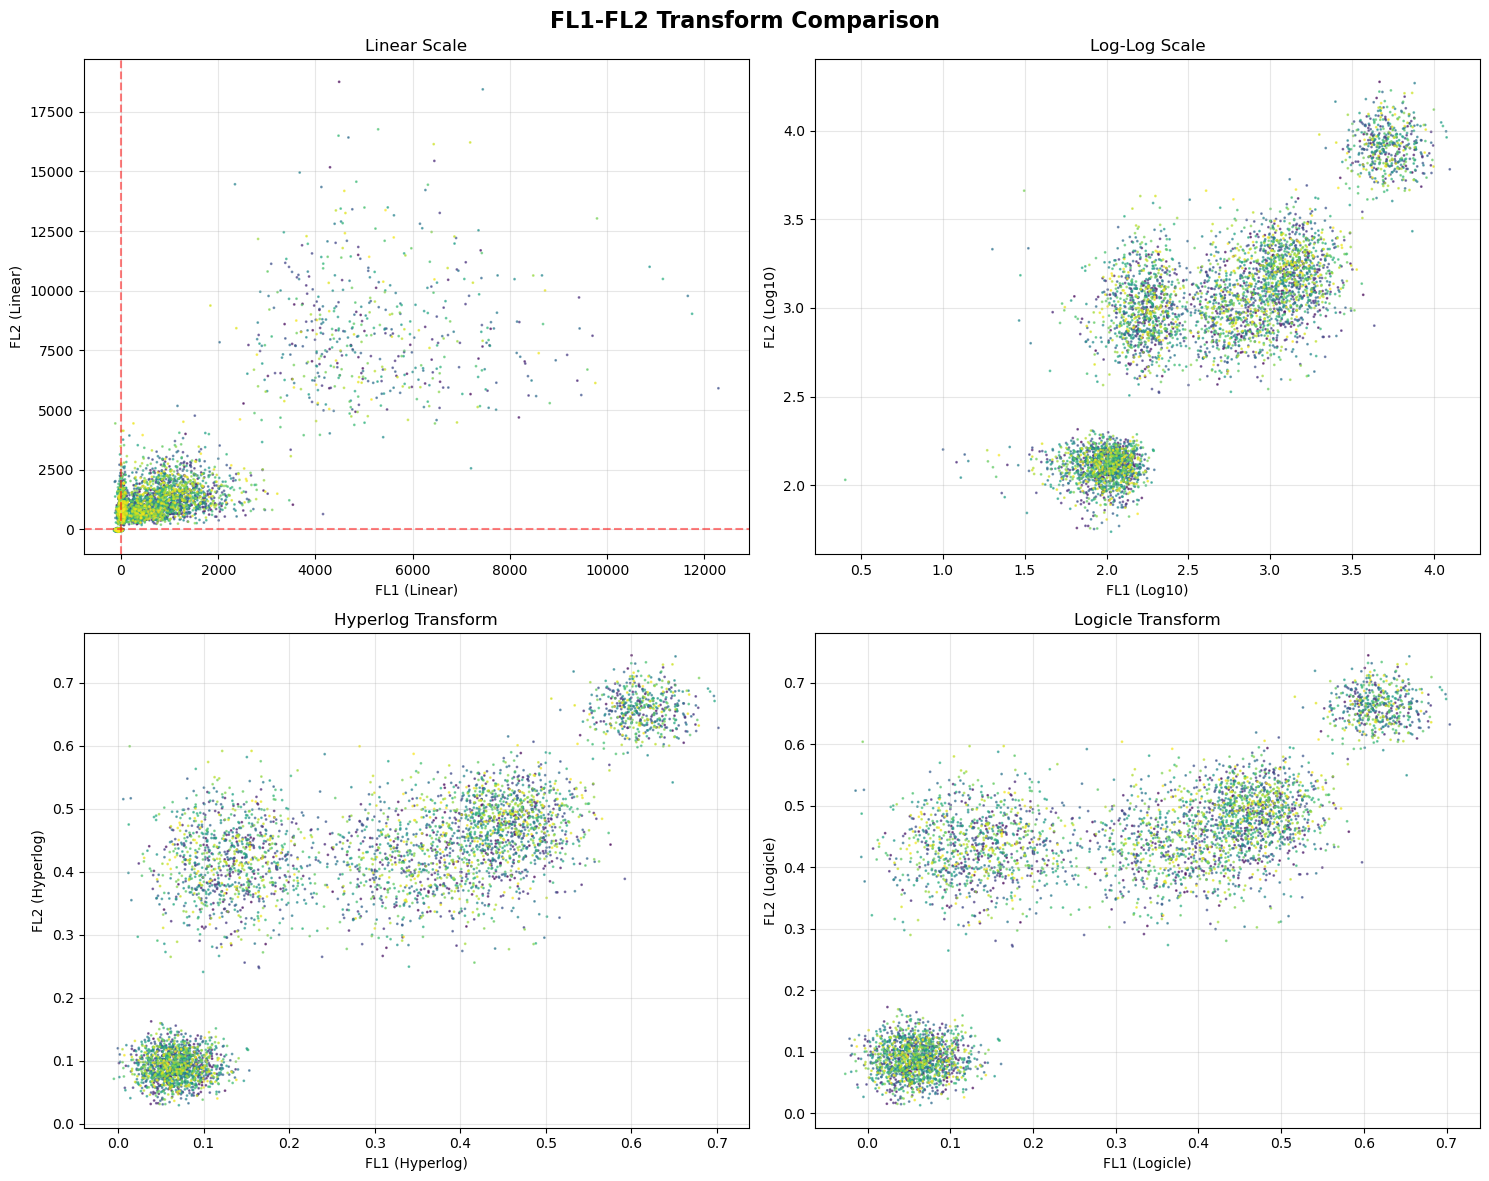

In [4]:
# Create the comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('FL1-FL2 Transform Comparison', fontsize=16, fontweight='bold')

# Common plot parameters
plot_alpha = 0.6
plot_s = 1  # point size
colormap = 'viridis'

# Sample subset for cleaner visualization (optional)
n_sample = 5000
sample_idx = np.random.choice(len(fcs_data), n_sample, replace=False)

# Plot 1: Linear scale
ax1 = axes[0, 0]
scatter1 = ax1.scatter(linear_data[sample_idx, 0], linear_data[sample_idx, 1], 
                      alpha=plot_alpha, s=plot_s, c=range(n_sample), cmap=colormap)
ax1.set_xlabel('FL1 (Linear)')
ax1.set_ylabel('FL2 (Linear)')
ax1.set_title('Linear Scale')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Plot 2: Log scale
ax2 = axes[0, 1] 
scatter2 = ax2.scatter(log_data[sample_idx, 0], log_data[sample_idx, 1],
                      alpha=plot_alpha, s=plot_s, c=range(n_sample), cmap=colormap)
ax2.set_xlabel('FL1 (Log10)')
ax2.set_ylabel('FL2 (Log10)')
ax2.set_title('Log-Log Scale')
ax2.grid(True, alpha=0.3)

# Plot 3: Hyperlog scale
ax3 = axes[1, 0]
scatter3 = ax3.scatter(hyperlog_data[sample_idx, 0], hyperlog_data[sample_idx, 1],
                      alpha=plot_alpha, s=plot_s, c=range(n_sample), cmap=colormap)
ax3.set_xlabel('FL1 (Hyperlog)')
ax3.set_ylabel('FL2 (Hyperlog)')
ax3.set_title('Hyperlog Transform')
ax3.grid(True, alpha=0.3)

# Plot 4: Logicle scale
ax4 = axes[1, 1]
scatter4 = ax4.scatter(logicle_data[sample_idx, 0], logicle_data[sample_idx, 1],
                      alpha=plot_alpha, s=plot_s, c=range(n_sample), cmap=colormap)
ax4.set_xlabel('FL1 (Logicle)')
ax4.set_ylabel('FL2 (Logicle)')
ax4.set_title('Logicle Transform')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fl1_fl2_transform_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Detailed Analysis: Population Separation

Let's analyze how well each transform separates the different populations.

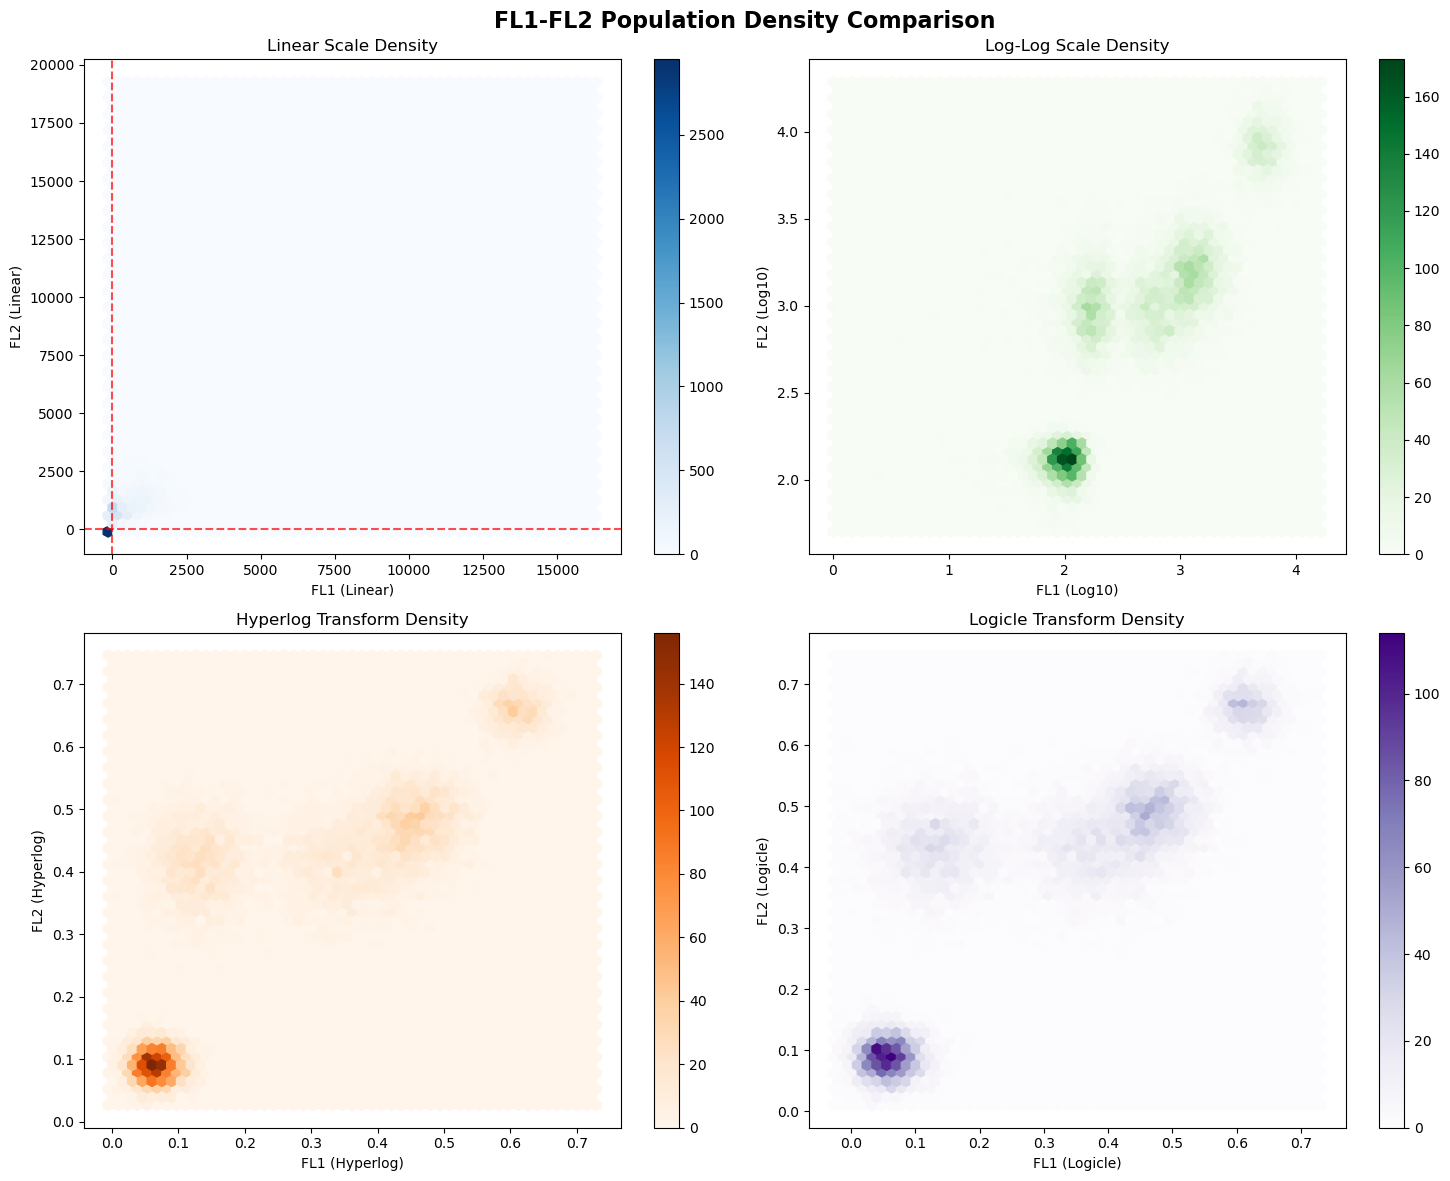

In [5]:
# Create density plots to better visualize population separation
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('FL1-FL2 Population Density Comparison', fontsize=16, fontweight='bold')

# Use hexbin for density visualization
gridsize = 50

# Linear scale density
ax1 = axes[0, 0]
hb1 = ax1.hexbin(linear_data[:, 0], linear_data[:, 1], gridsize=gridsize, cmap='Blues')
ax1.set_xlabel('FL1 (Linear)')
ax1.set_ylabel('FL2 (Linear)')
ax1.set_title('Linear Scale Density')
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7)
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.colorbar(hb1, ax=ax1)

# Log scale density
ax2 = axes[0, 1]
hb2 = ax2.hexbin(log_data[:, 0], log_data[:, 1], gridsize=gridsize, cmap='Greens')
ax2.set_xlabel('FL1 (Log10)')
ax2.set_ylabel('FL2 (Log10)')
ax2.set_title('Log-Log Scale Density')
plt.colorbar(hb2, ax=ax2)

# Hyperlog scale density
ax3 = axes[1, 0]
hb3 = ax3.hexbin(hyperlog_data[:, 0], hyperlog_data[:, 1], gridsize=gridsize, cmap='Oranges')
ax3.set_xlabel('FL1 (Hyperlog)')
ax3.set_ylabel('FL2 (Hyperlog)')
ax3.set_title('Hyperlog Transform Density')
plt.colorbar(hb3, ax=ax3)

# Logicle scale density
ax4 = axes[1, 1]
hb4 = ax4.hexbin(logicle_data[:, 0], logicle_data[:, 1], gridsize=gridsize, cmap='Purples')
ax4.set_xlabel('FL1 (Logicle)')
ax4.set_ylabel('FL2 (Logicle)')
ax4.set_title('Logicle Transform Density')
plt.colorbar(hb4, ax=ax4)

plt.tight_layout()
plt.savefig('fl1_fl2_density_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Transform Function Behavior Analysis

Let's examine how each transform function behaves across the data range.

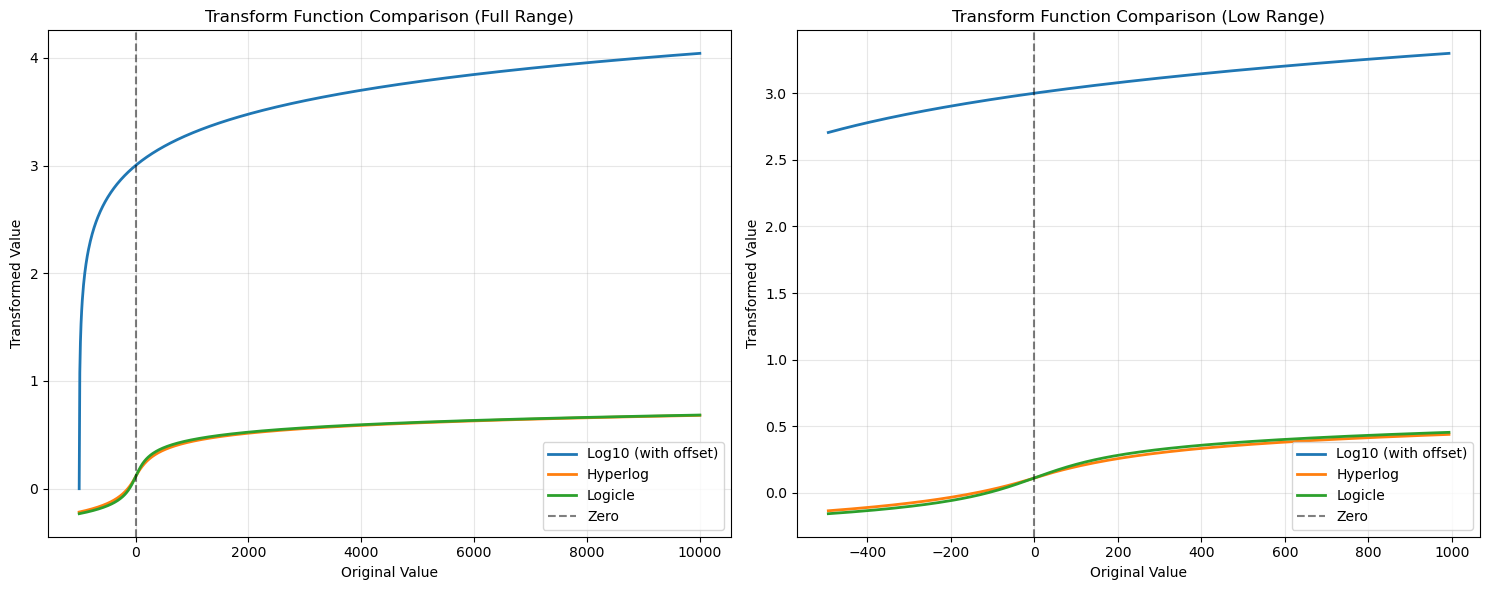

In [6]:
# Create test range covering negative to positive values
test_range = np.linspace(-1000, 10000, 1000)

# Apply transforms to test range
test_log = np.log10(test_range + abs(test_range.min()) + 1)
test_hyperlog = transforms._hyperlog(test_range, t=T, m=M, w=W, a=A)
test_logicle = transforms._logicle(test_range, t=T, m=M, w=W, a=A)

# Plot transform functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Full range
ax1.plot(test_range, test_log, label='Log10 (with offset)', linewidth=2)
ax1.plot(test_range, test_hyperlog, label='Hyperlog', linewidth=2)
ax1.plot(test_range, test_logicle, label='Logicle', linewidth=2)
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='Zero')
ax1.set_xlabel('Original Value')
ax1.set_ylabel('Transformed Value')
ax1.set_title('Transform Function Comparison (Full Range)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Zoomed in on negative/low positive region
mask = (test_range >= -500) & (test_range <= 1000)
ax2.plot(test_range[mask], test_log[mask], label='Log10 (with offset)', linewidth=2)
ax2.plot(test_range[mask], test_hyperlog[mask], label='Hyperlog', linewidth=2)
ax2.plot(test_range[mask], test_logicle[mask], label='Logicle', linewidth=2)
ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='Zero')
ax2.set_xlabel('Original Value')
ax2.set_ylabel('Transformed Value')
ax2.set_title('Transform Function Comparison (Low Range)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('transform_functions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Statistical Summary and Recommendations

Let's provide a statistical summary of how each transform affects the data.

In [7]:
import pandas as pd

# Calculate statistics for each transform
transforms_data = {
    'Linear': linear_data,
    'Log10': log_data, 
    'Hyperlog': hyperlog_data,
    'Logicle': logicle_data
}

stats_summary = []

for transform_name, data in transforms_data.items():
    for channel, channel_name in enumerate(['FL1', 'FL2']):
        channel_data = data[:, channel]
        stats_summary.append({
            'Transform': transform_name,
            'Channel': channel_name,
            'Min': channel_data.min(),
            'Max': channel_data.max(), 
            'Mean': channel_data.mean(),
            'Std': channel_data.std(),
            'Range': channel_data.max() - channel_data.min()
        })

stats_df = pd.DataFrame(stats_summary)
print("Statistical Summary of Transforms:")
print("=" * 60)
print(stats_df.round(3))

Statistical Summary of Transforms:
  Transform Channel      Min        Max      Mean       Std      Range
0    Linear     FL1 -148.779  16315.853   894.161  1644.681  16464.632
1    Linear     FL2  -99.418  19269.772  1537.071  2554.039  19369.189
2     Log10     FL1    0.000      4.217     2.598     0.604      4.217
3     Log10     FL2    1.702      4.288     2.864     0.583      2.586
4  Hyperlog     FL1   -0.006      0.730     0.271     0.197      0.736
5  Hyperlog     FL2    0.027      0.746     0.356     0.192      0.719
6   Logicle     FL1   -0.028      0.731     0.276     0.205      0.760
7   Logicle     FL2    0.010      0.748     0.365     0.197      0.738


## 7. Conclusions and Recommendations

Based on the analysis above, here are the key findings:

### Transform Characteristics:

1. **Linear Scale**: 
   - Shows the raw data distribution
   - Negative values are visible and preserved
   - High dynamic range makes it difficult to see low-intensity populations

2. **Log-Log Scale**: 
   - Requires offset for negative values (loses information about true negatives)
   - Compresses high values, expands low values
   - Good separation of positive populations but doesn't handle negatives naturally

3. **Hyperlog Transform**: 
   - Handles negative values naturally
   - Linear around zero, logarithmic at high values
   - Good for data with both negative and positive values

4. **Logicle Transform**: 
   - Specifically designed for flow cytometry data
   - Bi-exponential function that handles negative values smoothly
   - Provides excellent separation of populations across full dynamic range
   - Most commonly used in modern flow cytometry analysis

### Recommendations:

- **For flow cytometry data with potential negative values**: Use **Logicle** or **Hyperlog**
- **For data that is strictly positive**: Traditional **Log** transform is sufficient
- **For initial data exploration**: **Linear** scale to understand raw data distribution
- **For publication/analysis**: **Logicle** is the current standard in flow cytometry

In [8]:
print("\n" + "="*60)
print("FLOWUTILS TRANSFORM COMPARISON COMPLETE")
print("="*60)
print(f"Total events analyzed: {len(fcs_data):,}")
print(f"Channels: FL1, FL2")
print(f"Transforms compared: Linear, Log10, Hyperlog, Logicle")
print(f"Output files:")
print(f"  - fl1_fl2_transform_comparison.png")
print(f"  - fl1_fl2_density_comparison.png")
print(f"  - transform_functions_comparison.png")
print("\nFlowUtils Pure Python Implementation")
print("- Zero C dependencies")
print("- NumPy 1.22+ compatible")
print("- Mathematical accuracy preserved")
print("="*60)


FLOWUTILS TRANSFORM COMPARISON COMPLETE
Total events analyzed: 10,000
Channels: FL1, FL2
Transforms compared: Linear, Log10, Hyperlog, Logicle
Output files:
  - fl1_fl2_transform_comparison.png
  - fl1_fl2_density_comparison.png
  - transform_functions_comparison.png

FlowUtils Pure Python Implementation
- Zero C dependencies
- NumPy 1.22+ compatible
- Mathematical accuracy preserved
